In [1]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    

import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

In [2]:
cfg = breaching.get_config(overrides=["case=PJ_image_custom", "attack=PJ_DLG"])
cfg.seed = 100
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case image_custom with server type honest_but_curious.


{'device': device(type='cuda', index=0), 'dtype': torch.float32}

In [3]:
from breaching.cases.models.custom_models import McMahan_32_32
from breaching.cases.models.vgg import VGG
from breaching.attacks.auxiliaries.mask_functions import mask_adaptative_layer_clip, mask_adaptative_clip, mask_quantile_clip, mask_quantile_layer_clip
from breaching.attacks.auxiliaries.mask_functions import mask_percentage_out_channels, mask_percentage_in_channels
import torch.nn as nn
import torch

# net = VGG("VGG16")
net = McMahan_32_32()
images = torch.rand((4, 3, 32, 32))
labels = nn.functional.one_hot(torch.randint(0, 9, size=(4,)), num_classes=10).float()
output = net(images)
loss = nn.CrossEntropyLoss()(output, labels)
grad = torch.autograd.grad(loss, net.parameters())


for mask_fn_cls in [mask_adaptative_layer_clip, mask_adaptative_clip, mask_quantile_clip, mask_quantile_layer_clip, mask_percentage_out_channels, mask_percentage_in_channels]:
    print(mask_fn_cls.__name__)
    for value in [0., 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        mask_fn = mask_fn_cls(value)
        mask_fn._generate_mask(grad)
        mask_number_to_true = 0
        mask_number = 0
        for mask in mask_fn.fixed_mask:
            mask_number_to_true += mask.sum()
            mask_number += torch.numel(mask)
        print(f"{value*100}: {100 - mask_number_to_true.item()/mask_number * 100:.5f}")
    print()

mask_adaptative_layer_clip
0.0: 0.00000
10.0: 89.36285
20.0: 96.18120
30.0: 98.59619
40.0: 99.47048
50.0: 99.79666
60.0: 99.91240
70.0: 99.95228
80.0: 99.97482
90.0: 99.98590

mask_adaptative_clip
0.0: 0.00000
10.0: 99.90100
20.0: 99.98850
30.0: 99.99661
40.0: 99.99801
50.0: 99.99903
60.0: 99.99930
70.0: 99.99949
80.0: 99.99954
90.0: 99.99963

mask_quantile_clip
0.0: 0.00000
10.0: 0.00000
20.0: 0.00000
30.0: 0.00000
40.0: 0.00000
50.0: 0.00000
60.0: 60.00000
70.0: 70.00000
80.0: 80.00000
90.0: 89.99995

mask_quantile_layer_clip
0.0: 0.00000
10.0: 0.01169
20.0: 0.49812
30.0: 0.74714
40.0: 0.99620
50.0: 1.37580
60.0: 1.65092
70.0: 69.99995
80.0: 79.99991
90.0: 89.99986

mask_percentage_out_channels
0.0: 100.00000
10.0: 90.05356
20.0: 80.10712
30.0: 70.12353
40.0: 60.17709
50.0: 50.00000
60.0: 40.05356
70.0: 30.10712
80.0: 20.12353
90.0: 10.17709

mask_percentage_in_channels
0.0: 100.00000
10.0: 90.04034
20.0: 80.05694
30.0: 70.09724
40.0: 60.07675
50.0: 50.01855
60.0: 40.05889
70.0: 30.0

### Instantiate all parties - And Procede a Masked Defense

In [4]:
import math
import copy
import pickle
import numpy as np
from omegaconf import open_dict
with open_dict(cfg):
    cfg.case.data.vocab_size = 100 # issue if not setup


# mask_dict = {
#     "mask_percentage_out_channels": [{"p": float(p)} for p in np.linspace(0.1, 0.9, 9)],
# }
mask_dict = {
    "mask_percentage_out_channels": [{"p": float(p)} for p in np.linspace(0.1, 0.9, 9)],
}
# mask_dict = {
#     "mask_adaptative_layer_clip": [{"clip_value": float(p)} for p in np.linspace(0.1, 0.9, 9)],
# }
# mask_list = ["mask_fixed_identity", "mask_fixed_bernoulli", "mask_fixed_layer", "mask_clip"]

# p_bernoulli = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# clip_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
p_bernoulli = None
clip_values = None
percentage_values = None

NUM_TRIALS = 3
RUN_EXP = False
RUN_NUMPBER = 0
SAVE_PATH = f"./testing/results_mask_percentage_out_channels_{RUN_NUMPBER}.pickle"

def get_setup(cfg, setup):
    user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
    attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
    server_payload = server.distribute_payload()
    shared_data, true_user_data = user.compute_local_updates(server_payload)
    return user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data
def main(cfg, setup):
    user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data = get_setup(cfg, setup)
    reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)
    metrics = breaching.analysis.report(
        reconstructed_user_data, 
        true_user_data,
        [server_payload], 
        server.model,
        order_batch=True,
        compute_full_iip=False, 
        cfg_case=cfg.case,
        setup=setup,
    )
    return metrics, reconstructed_user_data, true_user_data
def main_dict(mask_dict, cfg):
    results = {mask_fn: {} for mask_fn, _ in mask_dict.items()}
    results["cfg"] = copy.deepcopy(cfg)
    results["mask_dict"] = copy.deepcopy(mask_dict)
    results["images_saved"] = {}
    for mask_fn, mask_cfgs in mask_dict.items():
        run_number = 0
        results["images_saved"][mask_fn] = {}
        for mask_cfg in mask_cfgs:
            cfg = copy.deepcopy(results["cfg"]) # reset to initial config
            with open_dict(cfg):
                cfg.case.model = "VGG16"
                cfg.attack.objective.mask_fn = mask_fn
                for key, value in mask_cfg.items():
                    cfg.attack.objective[key] = value
            results[mask_fn][run_number] = {}
            results[mask_fn][run_number]["mask_cfg"] = mask_cfg
            results[mask_fn][run_number]["cfg"] = cfg
            for trial in range(NUM_TRIALS):
                logging.info(f"mask_fn: {mask_fn} | mask_cfg: {mask_cfg} | trial: {trial}")
                metrics, reconstructed_user_data, true_user_data = main(cfg, setup)
                results[mask_fn][run_number][trial] = metrics
            results["images_saved"][mask_fn][run_number] = {}
            # results["images_saved"][mask_fn][run_number]["mask_cfg"] = mask_cfg
            results["images_saved"][mask_fn][run_number]["metrics"] = metrics
            results["images_saved"][mask_fn][run_number]["reconstructed_user_data"] = reconstructed_user_data
            results["images_saved"][mask_fn][run_number]["true_user_data"] = true_user_data
            run_number += 1

    with open(SAVE_PATH, 'wb') as file:
        pickle.dump(results, file, protocol=pickle.HIGHEST_PROTOCOL)
if RUN_EXP:
    main_dict(mask_dict, cfg)

### Result Analysis

In [5]:
import pickle

# SAVE_PATH = ["./testing/results/results_percentage_clean.pickle"]
SAVE_PATH = [
    "./testing//results/results_mask_adaptative_clip_0.pickle",
    "./testing//results/results_mask_adaptative_layer_clip_0.pickle",
    "./testing//results/results_mask_fixed_bernoulli_0.pickle",
    "./testing//results/results_mask_fixed_layer_0.pickle",
    "./testing//results/results_mask_quantile_clip_0.pickle",
    "./testing//results/results_mask_quantile_layer_clip_0.pickle",
    "./testing//results/results_mask_percentage_in_channels_0.pickle",
    "./testing//results/results_mask_percentage_out_channels_0.pickle",
]
saved_dico = []
for path in SAVE_PATH:
    with open(path, 'rb') as file:
        saved_dico.append(pickle.load(file))
    print(saved_dico[-1].keys())


dict_keys(['mask_adaptative_clip', 'images_saved', 'cfg', 'mask_dict'])
dict_keys(['mask_adaptative_layer_clip', 'images_saved', 'cfg', 'mask_dict'])
dict_keys(['mask_fixed_bernoulli', 'images_saved', 'cfg', 'mask_dict'])
dict_keys(['mask_fixed_layer', 'images_saved', 'cfg', 'mask_dict'])
dict_keys(['mask_quantile_clip', 'images_saved', 'cfg', 'mask_dict'])
dict_keys(['mask_quantile_layer_clip', 'images_saved', 'cfg', 'mask_dict'])
dict_keys(['mask_percentage_in_channels', 'images_saved', 'cfg', 'mask_dict'])
dict_keys(['mask_percentage_out_channels', 'cfg', 'mask_dict', 'images_saved'])


In [6]:
def combine_saved_dicos(saved_dico):
    results = {}
    for dico in saved_dico:
        for key, value in dico.items():
            if key not in results:
                results[key] = value
            else:
                results[key].update(value)
    return results
results = combine_saved_dicos(saved_dico)
for key in results.keys():
    print(key)

mask_adaptative_clip
images_saved
cfg
mask_dict
mask_adaptative_layer_clip
mask_fixed_bernoulli
mask_fixed_layer
mask_quantile_clip
mask_quantile_layer_clip
mask_percentage_in_channels
mask_percentage_out_channels


In [7]:
MASK_NAME = [key for key in results.keys() if "mask" in key and not "dict" in key]
for mask_name in MASK_NAME:
    print(results[mask_name].keys())

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
dict_keys([0, 1, 2, 3, 4])
dict_keys([0, 1, 2, 3, 4])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [12]:
import copy
import math

def average_metrics_trials(metrics, num_trials=None):
    if num_trials is None:
        if "mask_cfg" and "cfg" in metrics.keys():
            num_trials = len(metrics.keys()) - 2
        elif "mask_cfg" or "cfg" in metrics.keys():
            num_trials = len(metrics.keys()) - 1
        else:
            num_trials = len(metrics.keys())
    res_dico = {}
    for i in range(num_trials):
        for key in metrics[i].keys():
            if key == "mask_cfg":
                continue
            elif key in res_dico:
                res_dico[key] += metrics[i][key]
            else:
                res_dico[key] = copy.deepcopy(metrics[i][key])
    for key in res_dico.keys():
        if key != "order":
            res_dico[key] /= num_trials
    return res_dico

def variance_metrics_trials(metrics, mean_value, num_trials=None):
    if num_trials is None:
        if "mask_cfg" and "cfg" in metrics.keys():
            num_trials = len(metrics.keys()) - 2
        elif "mask_cfg" or "cfg" in metrics.keys():
            num_trials = len(metrics.keys()) - 1
        else:
            num_trials = len(metrics.keys())
    res_dico = {}
    for i in range(num_trials):
        for key in metrics[i].keys():
            if key == "mask_cfg":
                continue
            elif key in res_dico:
                res_dico[key] += (metrics[i][key] - mean_value[key])**2
            else:
                res_dico[key] = copy.deepcopy(metrics[i][key])
    for key in res_dico.keys():
        if key != "order":
            res_dico[key] /= num_trials
            res_dico[key] = math.sqrt(res_dico[key])
    return res_dico

def summarize_score_trials(metrics):
    average_dico = {}
    variance_dico = {}
    for mask in metrics.keys():
        if "mask" in mask and mask != "mask_dict":
            average_dico[mask] = {}
            simpler_metrics = []
            variance_dico[mask] = {}
            for exp in metrics[mask].keys():
                if exp in range(10):
                    average_dico[mask][exp] = average_metrics_trials(metrics[mask][exp])
                    variance_dico[mask][exp] = variance_metrics_trials(metrics[mask][exp], average_dico[mask][exp])
                else:
                    simpler_metrics.append(metrics[mask][exp])
            if simpler_metrics != []:
                average_dico[mask]["avg"] = breaching.utils.avg_n_dicts(simpler_metrics)
    return average_dico, variance_dico

average_dico, variance_dico = summarize_score_trials(results)
for mask_name in MASK_NAME:
    print(f"{mask_name: <30}: {average_dico[mask_name].keys()}")

mask_adaptative_clip          : dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
mask_adaptative_layer_clip    : dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
mask_fixed_bernoulli          : dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
mask_fixed_layer              : dict_keys([0, 1, 2, 3, 4, 5, 6, 7])
mask_quantile_clip            : dict_keys([0, 1, 2, 3, 4])
mask_quantile_layer_clip      : dict_keys([0, 1, 2, 3, 4])
mask_percentage_in_channels   : dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
mask_percentage_out_channels  : dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])


In [13]:
from breaching.attacks.auxiliaries.mask_functions import mask_lookup

def extract_one_metric(average_dico, key):
    res_key = []
    for key1 in average_dico.keys():
        if "mask" in key1 and key1 != "mask_dict":
            for key2 in average_dico[key1].keys():
                # if not (key1 == "mask_fixed_bernoulli" and key2 == "avg"):
                #     res_key.append(average_dico[key1][key2][key])
                res_key.append(average_dico[key1][key2][key])
    return res_key

MASK_TO_STR = {
    "mask_adaptative_clip": "AClip",
    "mask_adaptative_layer_clip": "ALClip",
    "mask_fixed_bernoulli": "Ber",
    "mask_fixed_layer": "FL",
    "mask_quantile_clip": "QClip",
    "mask_quantile_layer_clip": "QLClip",
    "mask_percentage_in_channels": "PIn",
    "mask_percentage_out_channels": "POut",
}

def extract_one_metric_dict(average_dico, key):
    res_key = {}
    for mask_name in average_dico.keys():
        if "mask" in mask_name and mask_name != "mask_dict":
            for exp in average_dico[mask_name].keys():
                # if not (key1 == "mask_fixed_bernoulli" and key2 == "avg"):
                #     res_key.append(average_dico[key1][key2][key])
                param = list(results["mask_dict"][mask_name][exp].values())[0]
                if type(param) == float:
                    res_key[f"{MASK_TO_STR[mask_name]}({param:.1f})"] = round(average_dico[mask_name][exp][key], 4)
                else:
                    res_key[f"{MASK_TO_STR[mask_name]}({param})"] = round(average_dico[mask_name][exp][key], 4)
    return res_key

def compute_sparsity(average_dico, net=McMahan_32_32()):
    net = McMahan_32_32()
    images = torch.rand((4, 3, 32, 32))
    labels = nn.functional.one_hot(torch.randint(0, 9, size=(4,)), num_classes=10).float()
    output = net(images)
    loss = nn.CrossEntropyLoss()(output, labels)
    grad = torch.autograd.grad(loss, net.parameters())
    sparsity = {}
    for mask_name in average_dico.keys():
        if "mask" in mask_name and mask_name != "mask_dict":
            for exp in average_dico[mask_name].keys():
                # if not (key1 == "mask_fixed_bernoulli" and key2 == "avg"):
                #     res_key.append(average_dico[key1][key2][key])
                param = list(results["mask_dict"][mask_name][exp].values())[0]
                mask_fn = mask_lookup[mask_name](param)
                mask_fn._generate_mask(grad)
                if type(param) == float:
                    sparsity[f"{MASK_TO_STR[mask_name]}({param:.1f})"] = round(mask_fn.get_sparsity().item(), 4)
                else:
                    sparsity[f"{MASK_TO_STR[mask_name]}({param})"] = round(mask_fn.get_sparsity().item(), 4)
    return sparsity

print(extract_one_metric_dict(average_dico, "mse"))
average_dico["sparsity"] = compute_sparsity(average_dico)


{'AClip(0.1)': 0.0742, 'AClip(0.2)': 0.1734, 'AClip(0.3)': 0.131, 'AClip(0.4)': 0.1254, 'AClip(0.5)': 0.1396, 'AClip(0.6)': 0.1317, 'AClip(0.7)': 0.1305, 'AClip(0.8)': 0.1231, 'AClip(0.9)': 0.1199, 'ALClip(0.1)': 0.0141, 'ALClip(0.2)': 0.0297, 'ALClip(0.3)': 0.0609, 'ALClip(0.4)': 0.0693, 'ALClip(0.5)': 0.1049, 'ALClip(0.6)': 0.134, 'ALClip(0.7)': 0.1552, 'ALClip(0.8)': 0.1498, 'ALClip(0.9)': 0.1617, 'Ber(0.1)': 0.0554, 'Ber(0.2)': 0.0474, 'Ber(0.3)': 0.0381, 'Ber(0.4)': 0.0499, 'Ber(0.5)': 0.066, 'Ber(0.6)': 0.0623, 'Ber(0.7)': 0.0603, 'Ber(0.8)': 0.0543, 'Ber(0.9)': 0.0595, 'FL([0])': 0.1053, 'FL([1])': 0.1766, 'FL([2])': 0.1337, 'FL([3])': 0.1602, 'FL([4])': 0.0987, 'FL([5])': 0.1712, 'FL([6])': 0.1211, 'FL([7])': 0.1169, 'QClip(0.5)': 0.0055, 'QClip(0.6)': 0.0083, 'QClip(0.7)': 0.0078, 'QClip(0.8)': 0.0087, 'QClip(0.9)': 0.0157, 'QLClip(0.5)': 0.0484, 'QLClip(0.6)': 0.0363, 'QLClip(0.7)': 0.0576, 'QLClip(0.8)': 0.0381, 'QLClip(0.9)': 0.0499, 'PIn(0.1)': 0.0633, 'PIn(0.2)': 0.0878, 

In [ ]:
average_dico["sparsity"]

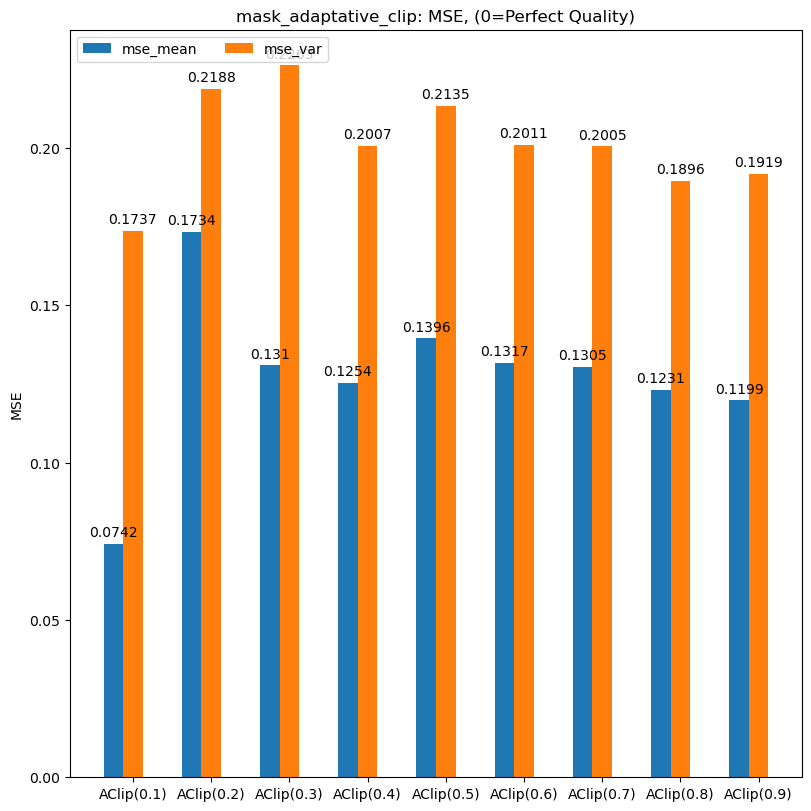

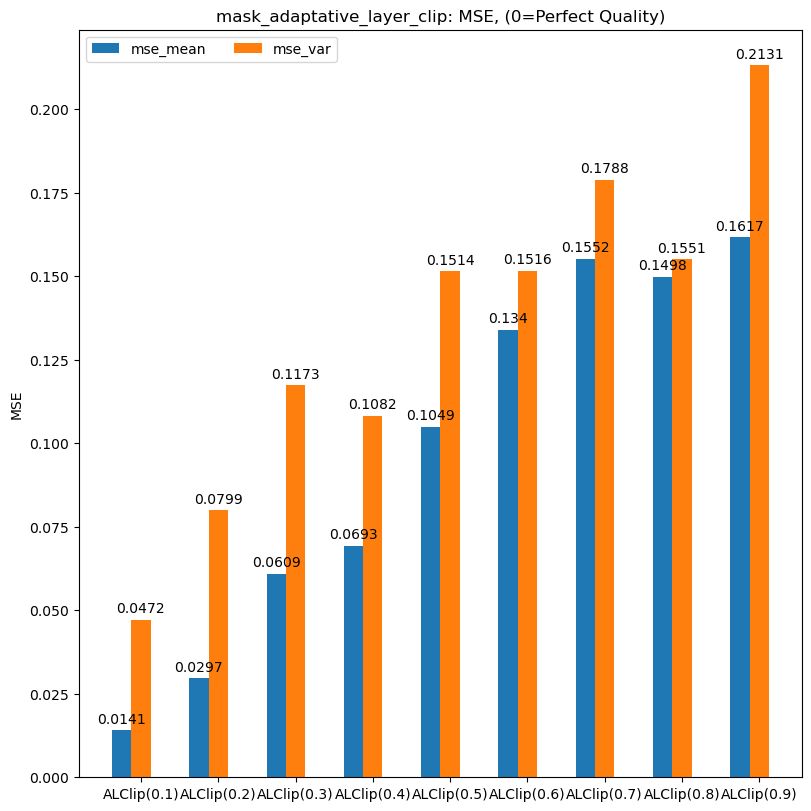

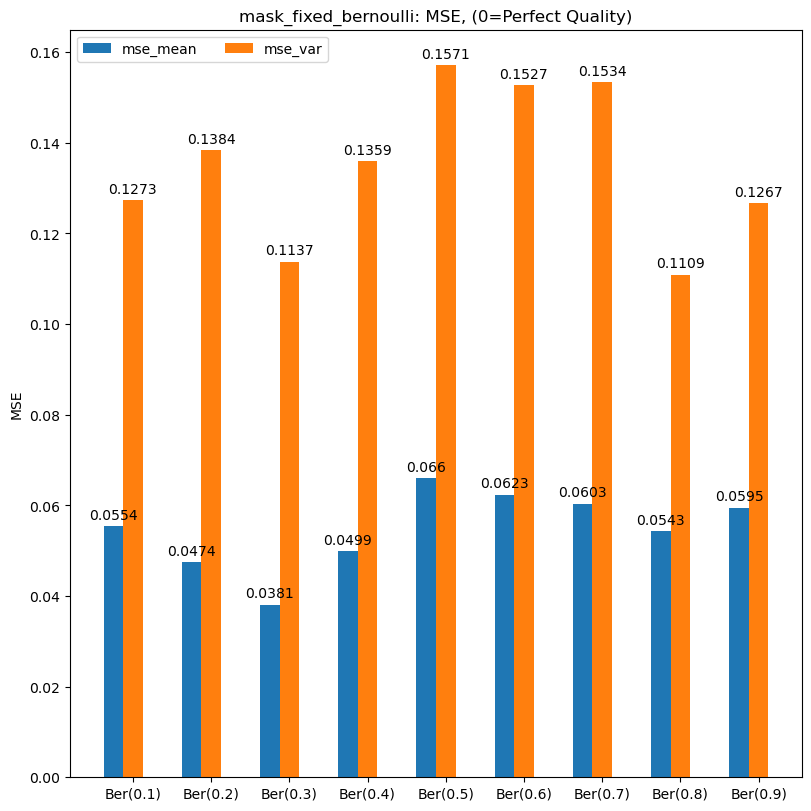

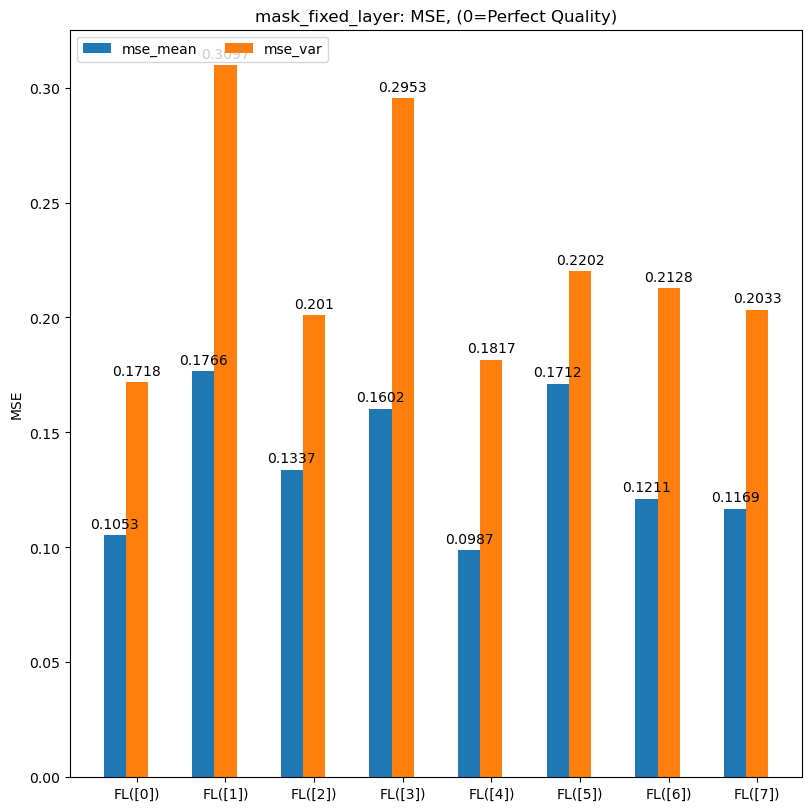

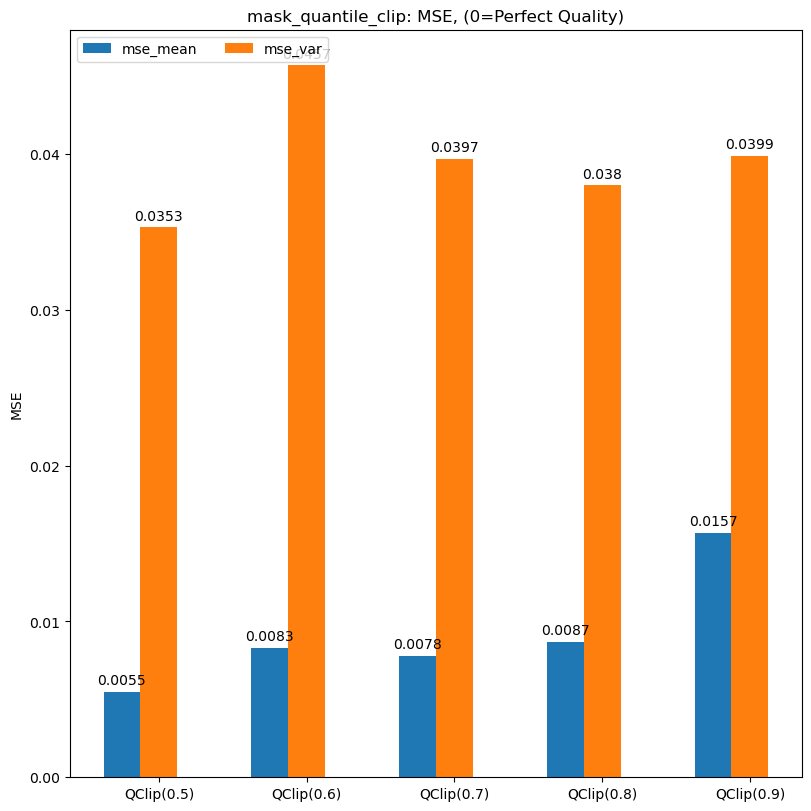

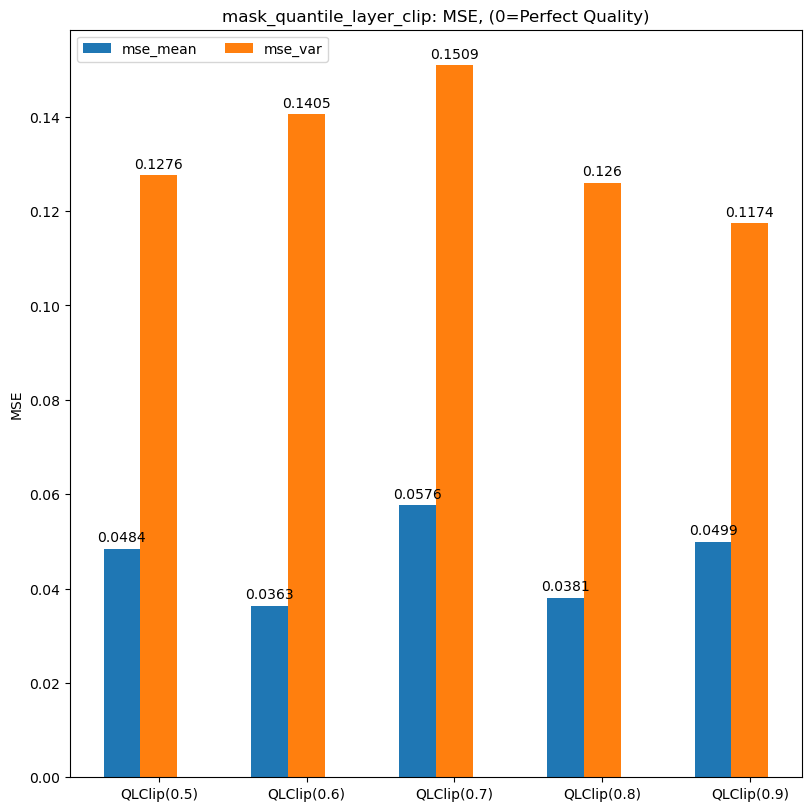

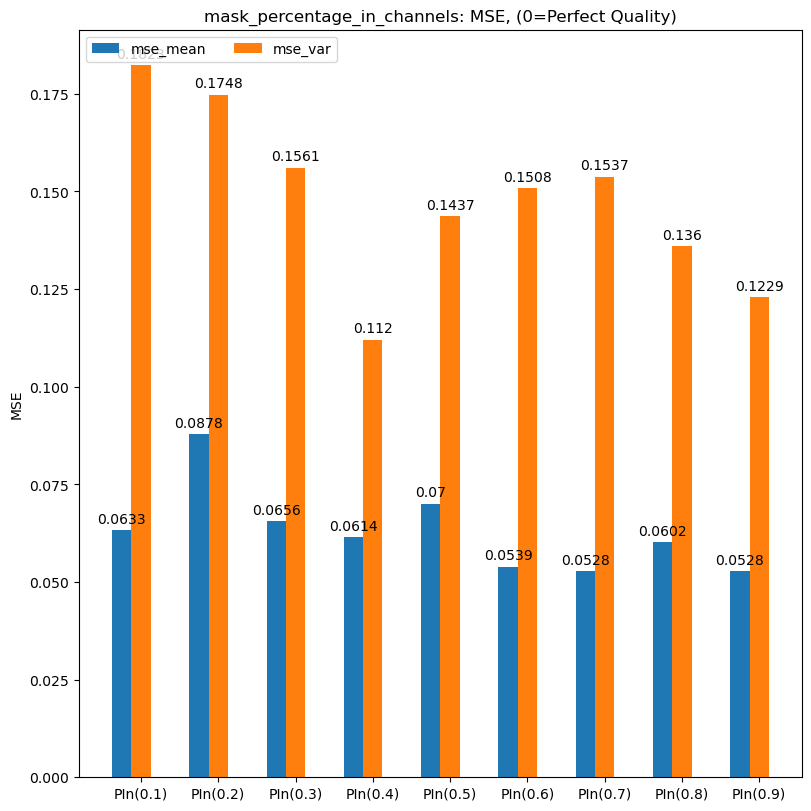

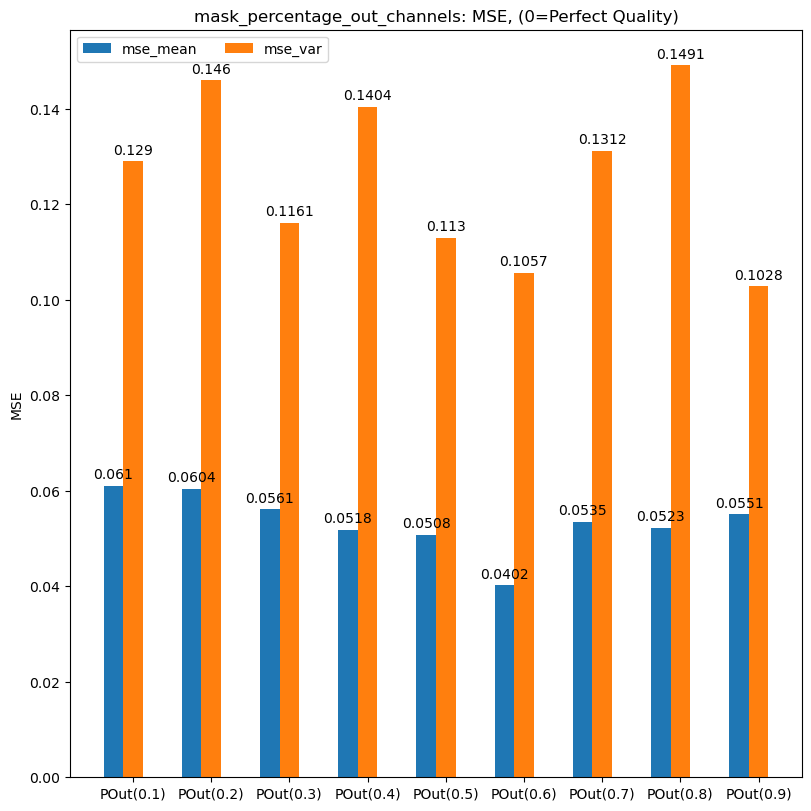

In [19]:
import matplotlib.pyplot as plt




EXTRACT_METRIC = "mse" # "psnr" or "ssim"
overall_mean = extract_one_metric_dict(average_dico, EXTRACT_METRIC)
overall_var = extract_one_metric_dict(variance_dico, EXTRACT_METRIC)

for mask_name in MASK_NAME:
    overall_mean_mask = {key: value for key,value in overall_mean.items() if MASK_TO_STR[mask_name] in key}
    overall_var_mask = {key: value for key,value in overall_var.items() if MASK_TO_STR[mask_name] in key}
    penguin_means = {EXTRACT_METRIC+"_mean": overall_mean_mask.values(), EXTRACT_METRIC+"_var": overall_var_mask.values()}
    # penpuin_var = {}
    species = list(overall_mean_mask.keys())
    fig, ax = plt.subplots(layout='constrained', figsize=(8, 8))
    x = np.arange(len(species))

    width = 0.25  # the width of the bars
    multiplier = 0
    for attribute, measurement in penguin_means.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    # width = 0.25  # the width of the bars
    # multiplier = 0
    # for attribute, measurement in penpuin_var.items():
    #     offset = width * multiplier
    #     rects = ax.bar(x + offset, measurement, width, label=attribute)
    #     ax.bar_label(rects, padding=3)
    #     multiplier += 1

    if "psnr" == EXTRACT_METRIC:
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('dB')
        ax.set_title(f'{mask_name}: PSNR for different mask')
        ax.set_xticks(x + width, species)
        ax.legend(loc='upper left', ncols=3)
        # ax.set_ylim(0,1.1)

    if "ssim" == EXTRACT_METRIC:
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('SSIM')
        ax.set_title(f'{mask_name}: SSIM for different masks (1=Perfect Quality)')
        ax.set_xticks(x + width, species)
        ax.legend(loc='upper left', ncols=3)
        # ax.set_ylim(0,1.1)

    if "mse" == EXTRACT_METRIC:
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('MSE')
        ax.set_title(f'{mask_name}: MSE, (0=Perfect Quality)')
        ax.set_xticks(x + width, species)
        ax.legend(loc='upper left', ncols=3)
        # ax.set_ylim(0,1.1)

plt.show()

In [117]:
grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
print(grid_shape)
print(len(rec_data.keys()))
print(2*(len(rec_data.keys())*grid_shape))

2
8
32


Files already downloaded and verified
self.cfg.objective.type: Masked-euclidean
Computing user update on user 0 in model mode: eval.


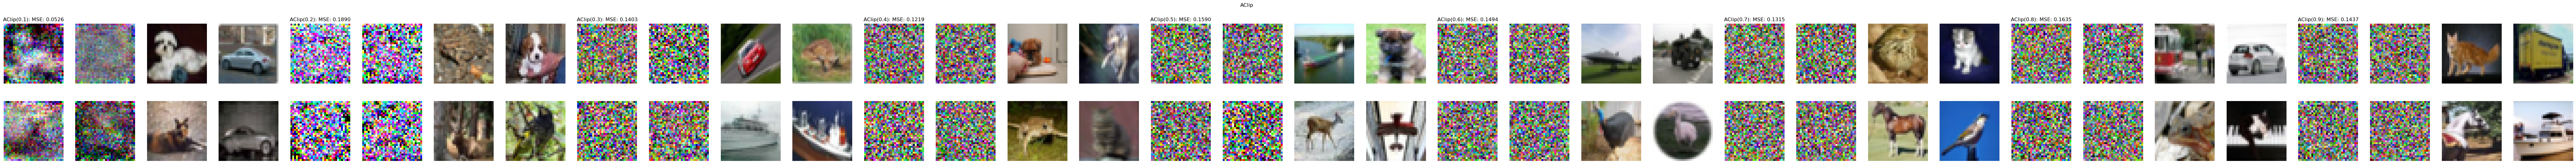

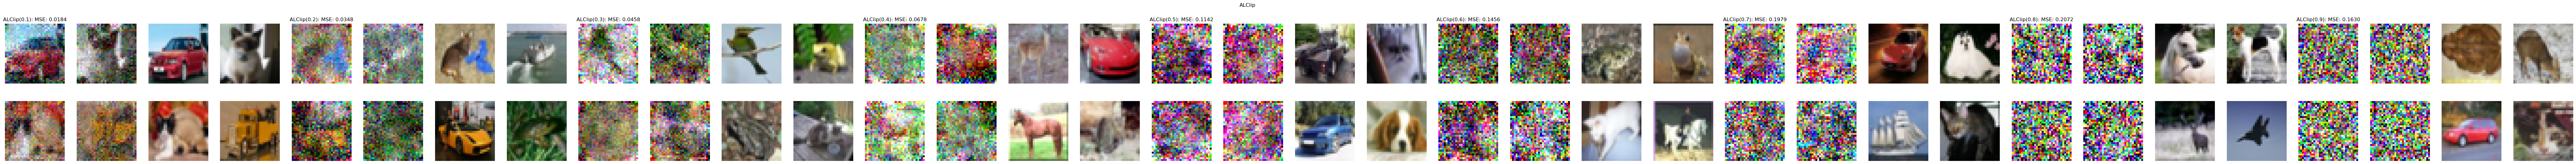

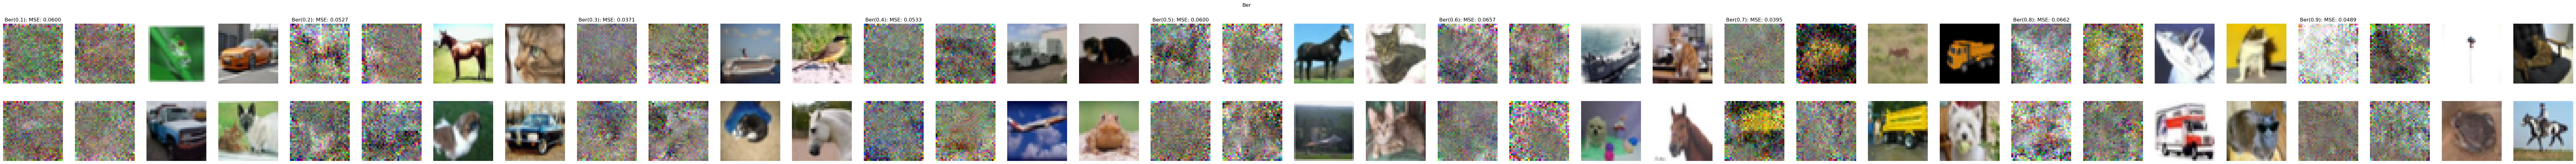

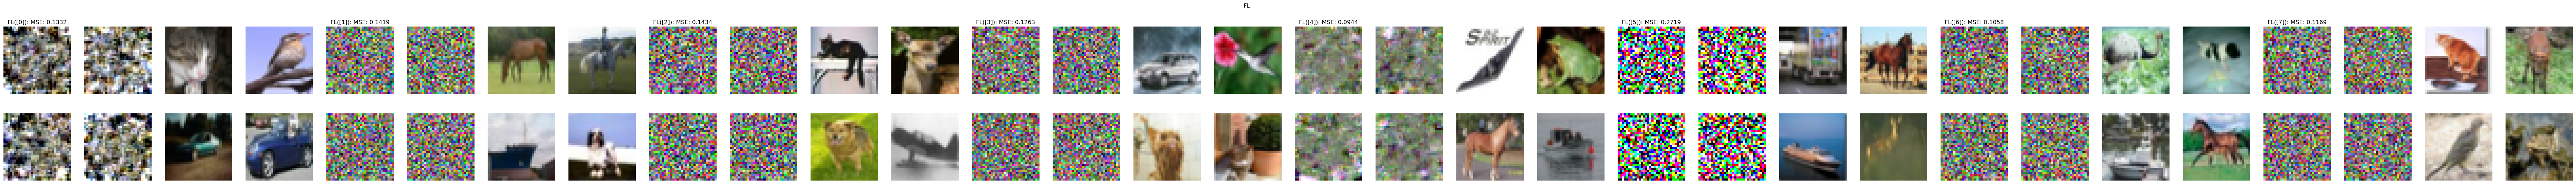

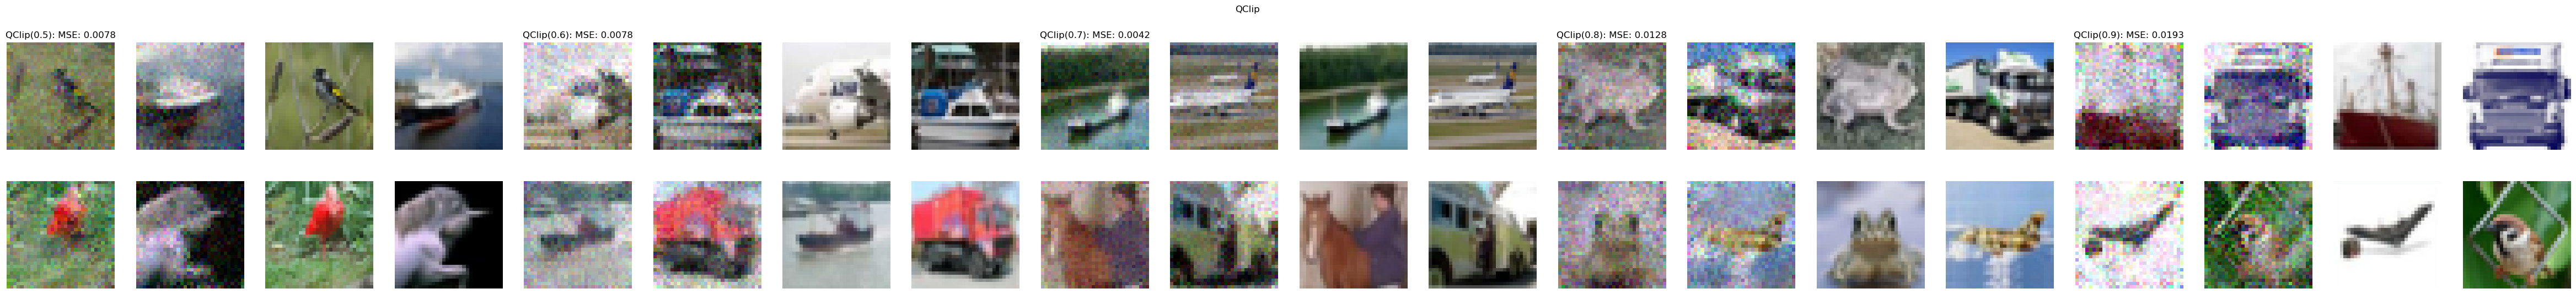

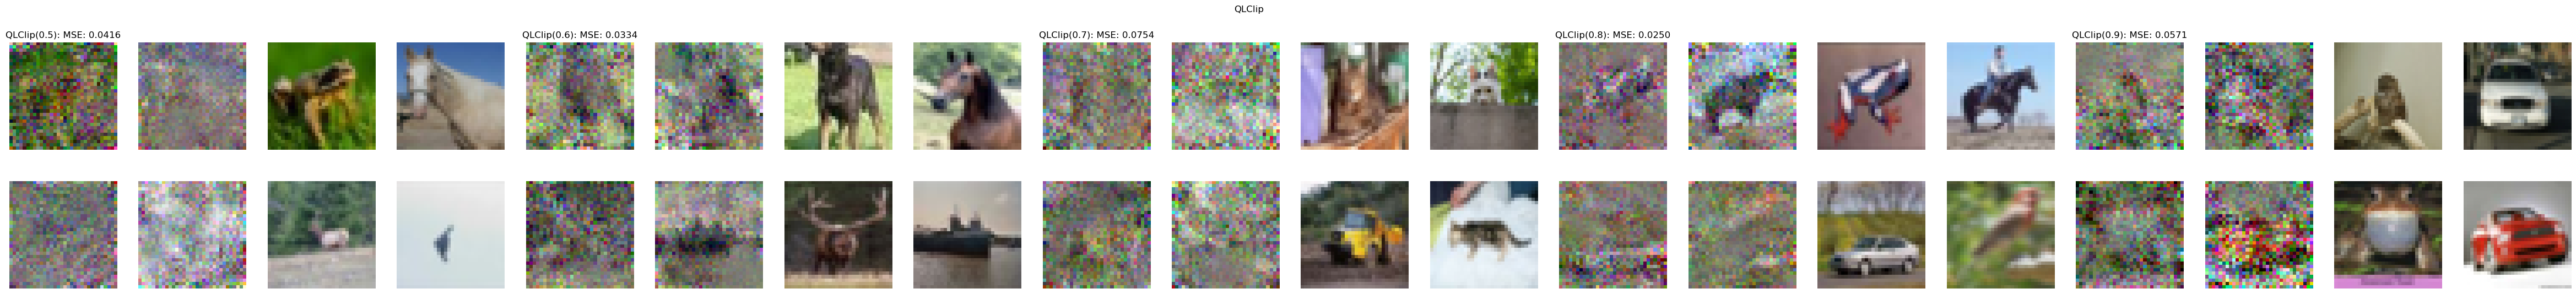

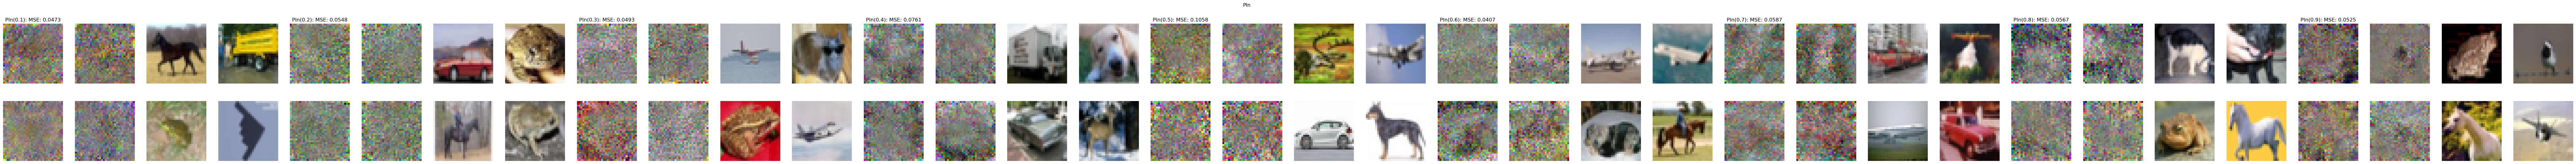

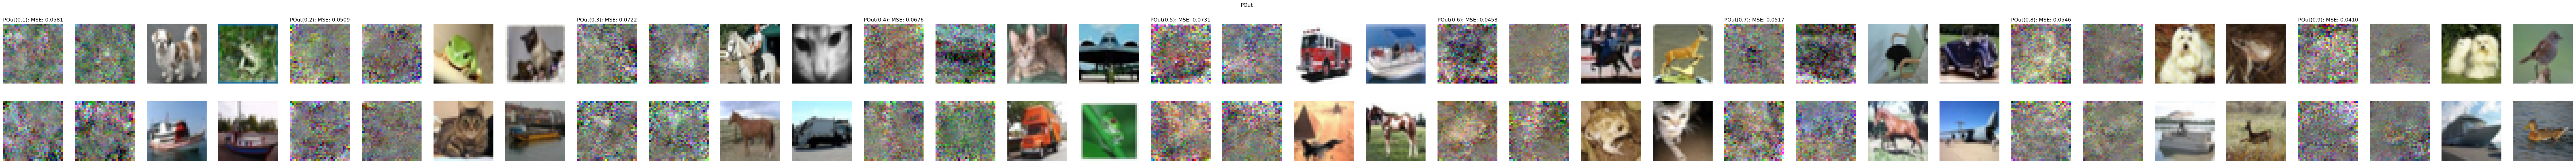

In [141]:
from omegaconf import open_dict

def get_user_and_rec_data(results, mask_fn):
    metrics = {}
    user_data = {}
    rec_data = {}
    mask_cfg = {}
    name_exp = {}
    try:
        for exp in results["images_saved"][mask_fn].keys():
            param = list(results["mask_dict"][mask_fn][exp-1].values())[0]
            if type(param) == float:
                name = f"{MASK_TO_STR[mask_fn]}({param:.1f})"
            else:
                name = f"{MASK_TO_STR[mask_fn]}({param})"
            f"{MASK_TO_STR[mask_fn]}({param:.1f})"
            metrics[exp] = results["images_saved"][mask_fn][exp]['metrics']
            rec_data[exp] = results["images_saved"][mask_fn][exp]['reconstructed_user_data']
            user_data[exp] = results["images_saved"][mask_fn][exp]['true_user_data']
            mask_cfg[exp] = results[mask_fn][exp-1]["mask_cfg"]
            name_exp[exp] = name
        v1 = True
    except:
        for exp in results["images_saved"][mask_fn].keys():
            param = list(results["mask_dict"][mask_fn][exp].values())[0]
            if type(param) == float:
                name = f"{MASK_TO_STR[mask_fn]}({param:.1f})"
            else:
                name = f"{MASK_TO_STR[mask_fn]}({param})"
            metrics[exp] = results["images_saved"][mask_fn][exp]['metrics']
            rec_data[exp] = results["images_saved"][mask_fn][exp]['reconstructed_user_data']
            user_data[exp] = results["images_saved"][mask_fn][exp]['true_user_data']
            mask_cfg[exp] = results[mask_fn][exp]["mask_cfg"]
            name_exp[exp] = name
        v1 = False
    return metrics, rec_data, user_data, mask_cfg, v1, name_exp

mask_name = MASK_NAME[0]
EXTRACT_METRIC = "mse" # "psnr" or "ssim"
overall = extract_one_metric_dict(average_dico, EXTRACT_METRIC)

with open_dict(cfg):
    cfg.attack.objective.mask_fn = mask_name
    cfg.attack.objective.p = 0.5
    cfg.attack.objective.clip_value = 0.5
    cfg.attack.objective.q = 0.5
    cfg.attack.objective.Layer = [0]
user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data = get_setup(cfg, setup)
dm = torch.as_tensor(user.dataloader.dataset.mean, **user.setup)[None, :, None, None]
ds = torch.as_tensor(user.dataloader.dataset.std, **user.setup)[None, :, None, None]
classes = user.dataloader.dataset.classes


for mask_name in MASK_NAME:
    scale = False
    print_labels = False
    metrics, rec_data, user_data, mask_cfg, v1, name_exp = get_user_and_rec_data(results, mask_name)
    metrics_to_extract = ["mse"]
    num_exp = len(rec_data.keys())
    
    overall_mask = {key: value for key,value in overall.items() if MASK_TO_STR[mask_name] in key}
    penguin_means = {EXTRACT_METRIC: overall_mask.values()}
    species = list(overall_mask.keys())
    
    data = rec_data[v1]["data"].clone().detach()
    grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
    s = 24 if data.shape[3] > 150 else 6
    fig, axes = plt.subplots(grid_shape, 2*(len(rec_data.keys())*grid_shape), figsize=(2*len(rec_data.keys())*s, s))
    for exp in range(v1,v1+num_exp):
        data_rec = rec_data[exp]["data"].clone().detach()
        labels_rec = rec_data[exp]["labels"].clone().detach() if rec_data[exp]["labels"] is not None else None

        data_user = user_data[exp]["data"].clone().detach()
        labels_user = user_data[exp]["labels"].clone().detach() if rec_data[exp]["labels"] is not None else None
        metric = {}
        for data, labels in zip([data_rec, data_user], [labels_rec, labels_user]):
            for metric_ in metrics_to_extract:
                metric[metric_] = metrics[exp][metric_]
            if labels is None:
                print_labels = False

            if scale:
                min_val, max_val = data.amin(dim=[2, 3], keepdim=True), data.amax(dim=[2, 3], keepdim=True)
                # print(f'min_val: {min_val} | max_val: {max_val}')
                data = (data - min_val) / (max_val - min_val)
            else:
                data.mul_(ds).add_(dm).clamp_(0, 1)
            data = data.to(dtype=torch.float32)

        if data.shape[0] == 1:
            plt.axis("off")
            plt.imshow(data[0].permute(1, 2, 0).cpu())
            if print_labels:
                plt.title(f"Data with label {classes[labels]}")
        else:
            # grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
            # s = 24 if data.shape[3] > 150 else 6
            # fig, axes = plt.subplots(grid_shape, 2*grid_shape, figsize=(2*s, s))
            _axes = axes[:, 2*(exp-v1)*grid_shape:2*(exp-v1+1)*grid_shape]
            label_classes = []
            # Reconstructed data
            _axes[:, :grid_shape].flatten()[0].set_title(f"{name_exp[exp]}: MSE: {metrics[exp]['mse']:.4f}")
            for i, (im, axis) in enumerate(zip(data_rec, _axes[:, :grid_shape].flatten())):
                axis.imshow(im.permute(1, 2, 0).cpu())
                if labels_rec is not None and print_labels:
                    label_classes.append(classes[labels_rec[i]])
                axis.axis("off")
            # User data
            for i, (im, axis) in enumerate(zip(data_user, _axes[:, grid_shape:].flatten())):
                axis.imshow(im.permute(1, 2, 0).cpu())
                if labels_user is not None and print_labels:
                    label_classes.append(classes[labels_user[i]])
                axis.axis("off")
            if print_labels:
                print(label_classes)
        fig.suptitle(MASK_TO_STR[mask_name])
    plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

"dict_keys(['mse', 'psnr', 'lpips', 'rpsnr', 'ssim', 'max_ssim', 'max_rpsnr', 'order', 'IIP-pixel', 'feat_mse', 'parameters', 'label_acc'])"

_slice_bernoulli = range(1, 1+9)
_slice_clip = range(11, 11+9)
_slice_percentage  = range(20, 20+9)
_slice_percentage_redo = range(29, 30 + 4)
_slice_layer_clip = range(34, 34+9)
_slice_quantile_clip = range(43, 43+5)
_slice_quantile_layer_clip = range(48, 48+5)
# dict_keys(['mask_adaptative_clip', 'images_saved', 'cfg', 'mask_dict'])
# dict_keys(['mask_adaptative_layer_clip', 'images_saved', 'cfg', 'mask_dict'])
# dict_keys(['mask_fixed_identity', 'mask_fixed_bernoulli', 'mask_fixed_layer', 'mask_clip'])
# dict_keys(['mask_quantile_clip', 'images_saved', 'cfg', 'mask_dict'])
# dict_keys(['mask_quantile_layer_clip', 'images_saved', 'cfg', 'mask_dict'])
slice_mask_lookup = {
    "mask_fixed_bernoulli": _slice_bernoulli,
    "mask_adaptative_clip": _slice_clip,
    "mask_percentage_in_channels": _slice_percentage,
    # "mask_percentage_in_channels": _slice_percentage_redo,
    "mask_adaptative_layer_clip": _slice_layer_clip,
    "mask_quantile_clip": _slice_quantile_clip,
    "mask_quantile_layer_clip": _slice_quantile_layer_clip,
}

_slice = [slice_mask_lookup[mask_name] for mask_name in MASK_NAME]

species = (
    ("Identity",) 
    + ("Ber(0.1)", "Ber(0.2)", "Ber(0.3)", "Ber(0.4)", "Ber(0.5)", "Ber(0.6)", "Ber(0.7)", "Ber(0.8)", "Ber(0.9)")
    + ("1 Fixed Layer",) 
    + ("Clip(0.1)", "Clip(0.2)", "Clip(0.3)", "Clip(0.4)", "Clip(0.5)", "Clip(0.6)", "Clip(0.7)", "Clip(0.8)", "Clip(0.9)")
    + ("%(0.1)", "%(0.2)", "%(0.3)", "%(0.4)", "%(0.5)", "%(0.6)", "%(0.7)", "%(0.8)", "%(0.9)")
    + ("%(0.1)", "%(0.01)", "%(0.001)", "%(0.0001)", "%(0.00001)")
    + ("AClip(0.1)", "AClip(0.2)", "AClip(0.3)", "AClip(0.4)", "AClip(0.5)", "AClip(0.6)", "AClip(0.7)", "AClip(0.8)", "AClip(0.9)")
    + ("Quant(0.5)", "Quant(0.6)", "Quant(0.7)", "Quant(0.8)", "Quant(0.9)")
    + ("LQuant(0.5)", "LQuant(0.6)", "LQuant(0.7)", "LQuant(0.8)", "LQuant(0.9)")
)
species = [species[i] for i in _slice]

penguin_means = {
    'mse': tuple(extract_one_metric(average_dico, "mse")),
    # 'psnr': tuple(extract_one_metric(average_dico, "psnr")),
    # 'lpips': tuple(extract_one_metric(average_dico, "lpips")),
    # 'rpsnr': tuple(extract_one_metric(average_dico, "rpsnr")),
    # 'ssim': tuple(extract_one_metric(average_dico, "ssim")),
    # 'max_ssim': tuple(extract_one_metric(average_dico, "max_ssim")),
    # 'max_rpsnr': tuple(extract_one_metric(average_dico, "max_rpsnr")),
    # 'IIP-pixel': tuple(extract_one_metric(average_dico, "IIP-pixel")),
    # 'feat_mse': tuple(extract_one_metric(average_dico, "feat_mse")),
}
# for key in penguin_means.keys():
#     penguin_means[key] = [penguin_means[key][i] for i in _slice]
# species = ("Ber(0.1)", "Ber(0.2)", "Ber(0.3)", "Ber(0.4)", "Ber(0.5)", "Ber(0.6)", "Ber(0.7)", "Ber(0.8)", "Ber(0.9)")

x = np.arange(len(species))  # the label locations
width = 0.25  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(8, 8))

for attribute, measurement in penguin_means.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

if "psnr" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('dB')
    ax.set_title(f'{MASK_NAME}: PSNR for different mask')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

if "ssim" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('SSIM')
    ax.set_title(f'{MASK_NAME}: SSIM for different masks (1=Perfect Quality)')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

if "mse" in penguin_means.keys():
    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('MSE')
    ax.set_title(f'{MASK_NAME}: MSE, (0=Perfect Quality)')
    ax.set_xticks(x + width, species)
    ax.legend(loc='upper left', ncols=3)
    # ax.set_ylim(0,1.1)

plt.show()

Files already downloaded and verified
self.cfg.objective.type: Masked-euclidean
Computing user update on user 0 in model mode: eval.


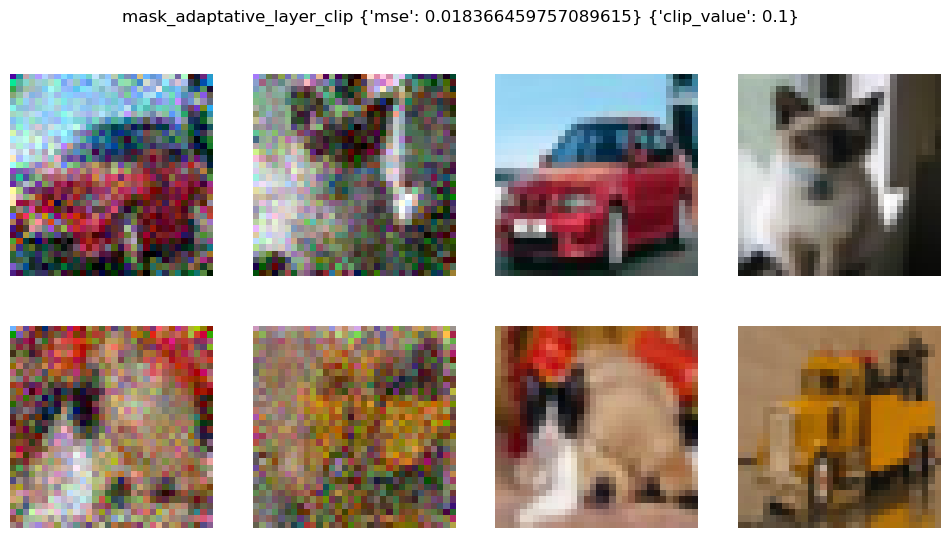

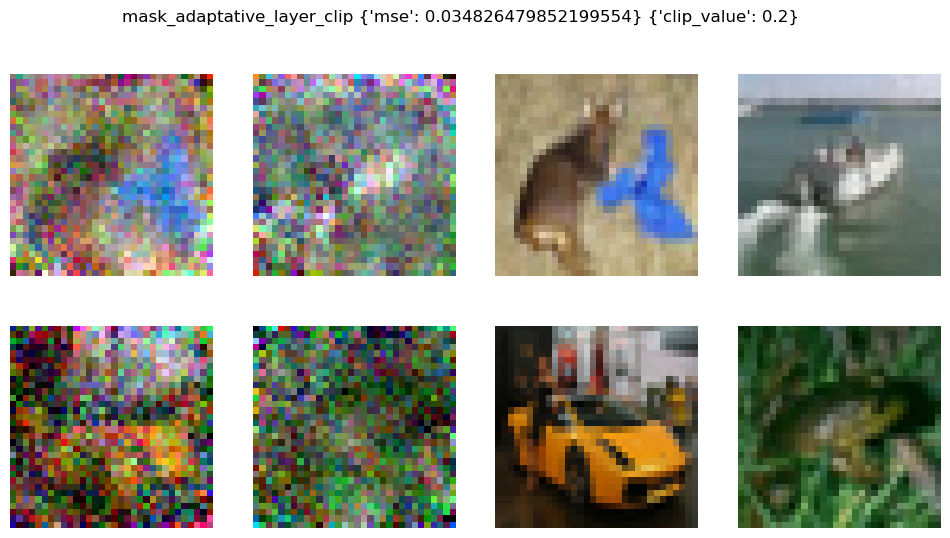

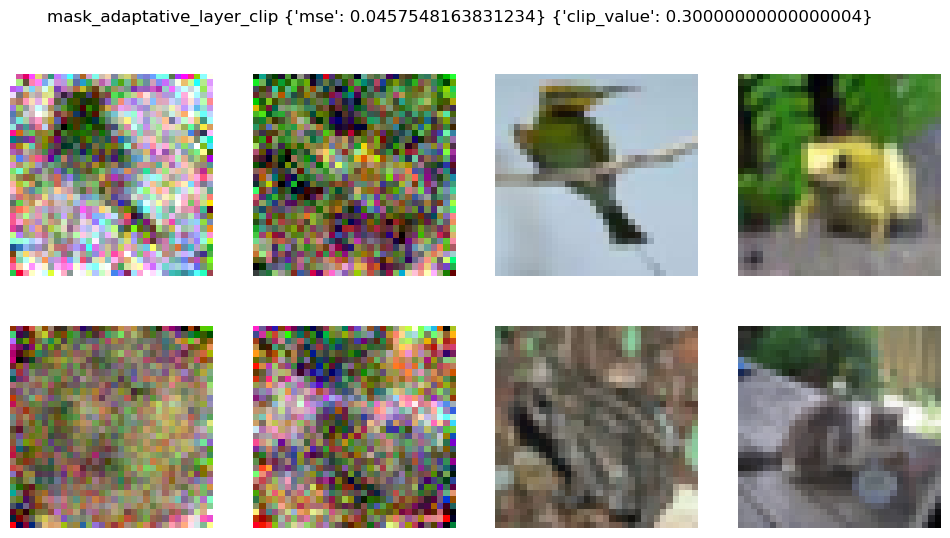

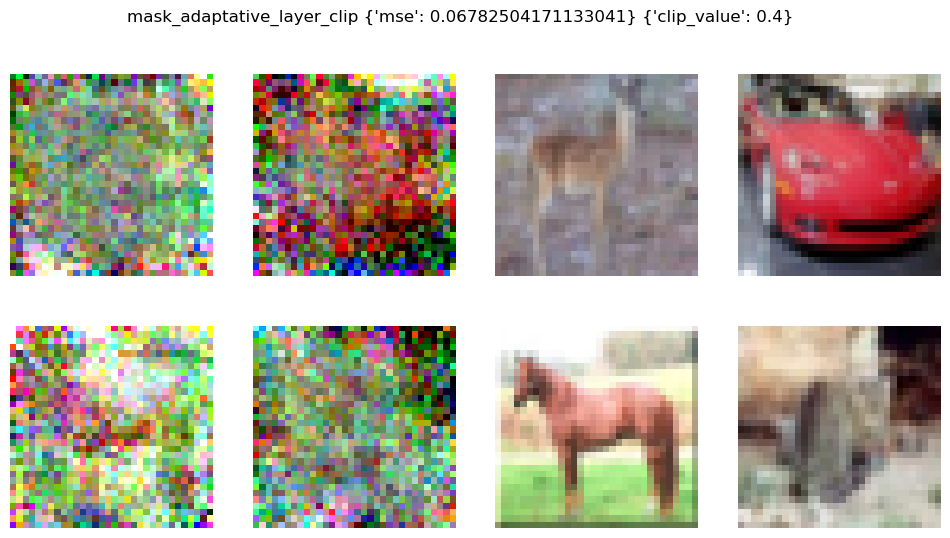

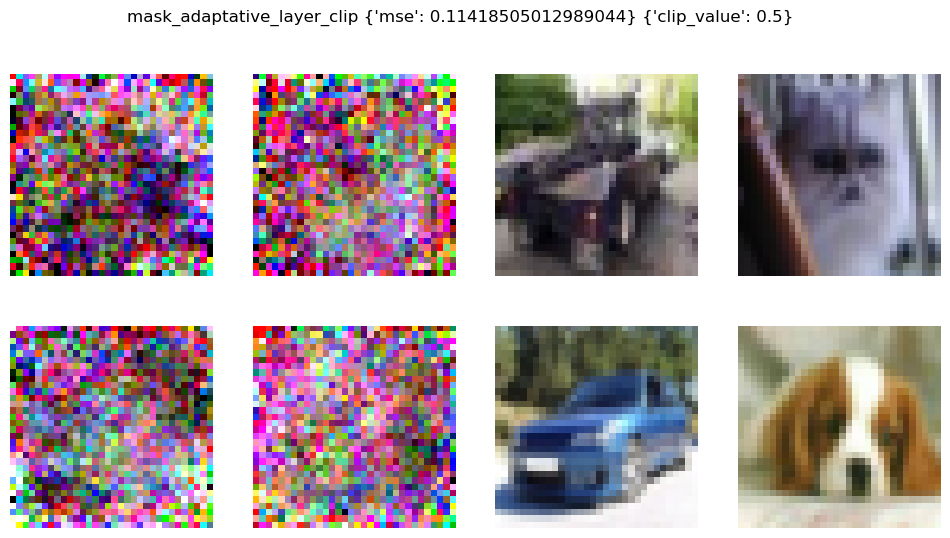

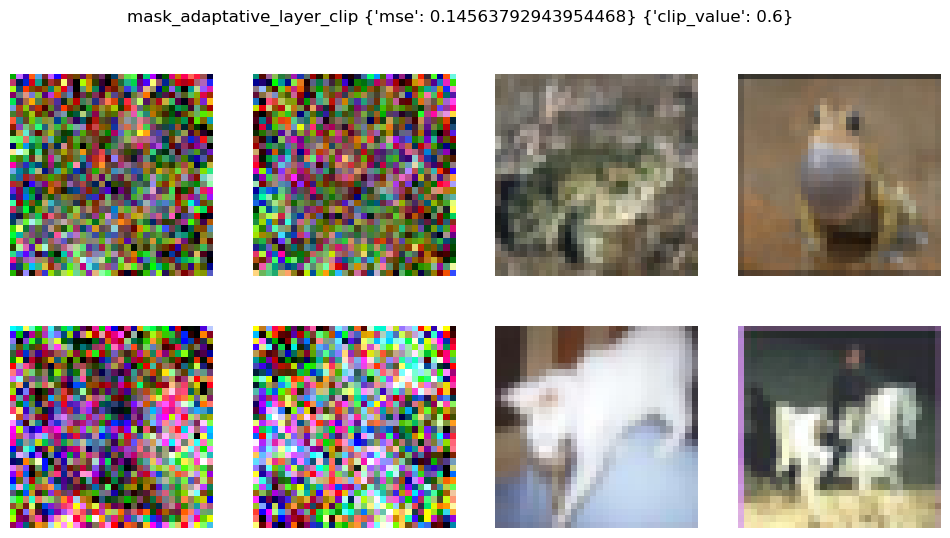

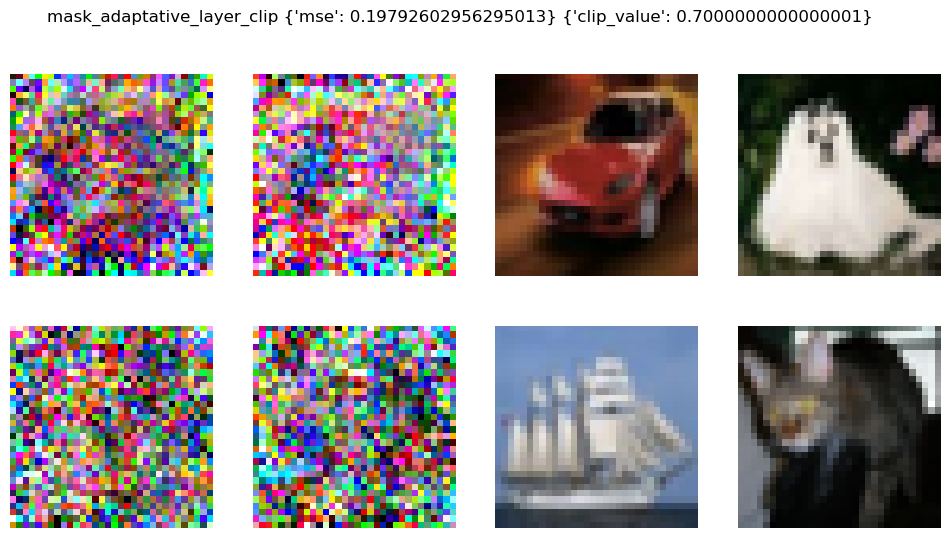

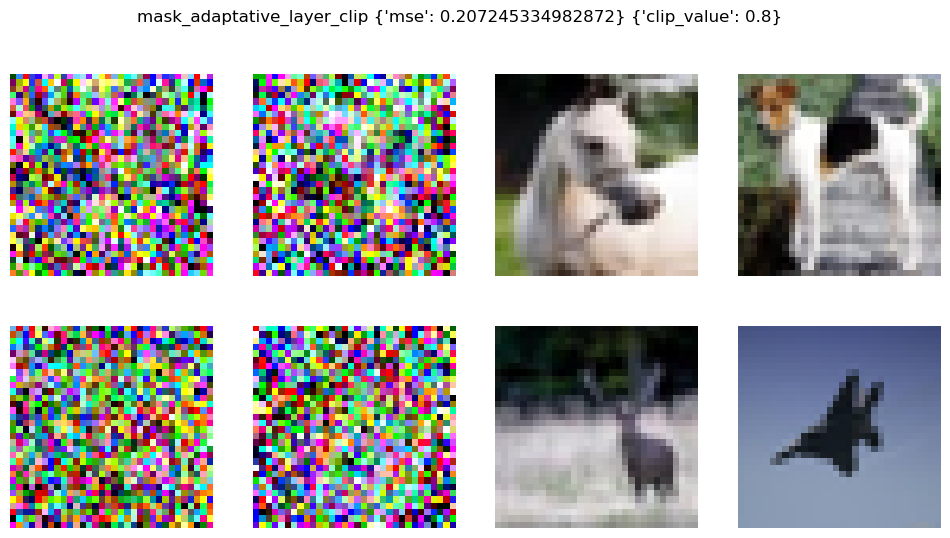

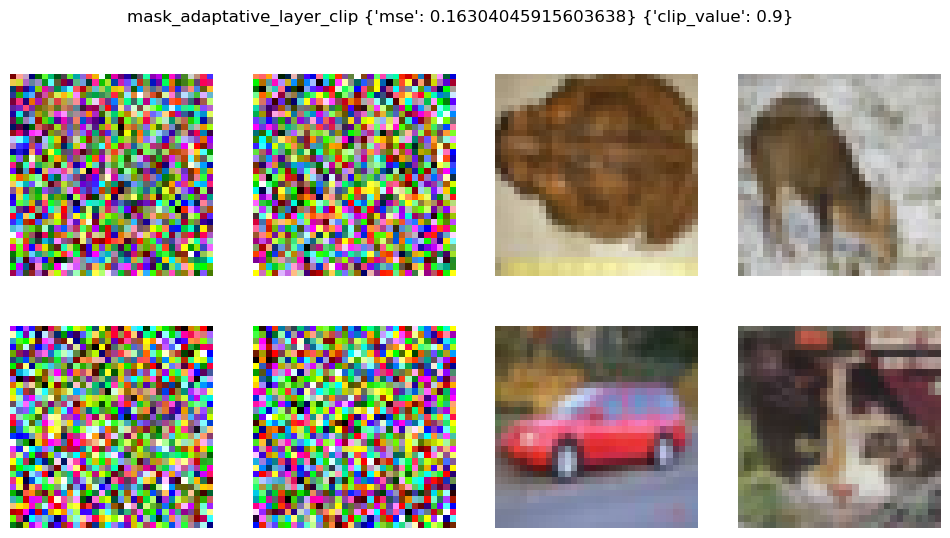

In [47]:
from omegaconf import open_dict

def get_user_and_rec_data(saved_dico, mask_fn):
    metrics = {}
    user_data = {}
    rec_data = {}
    mask_cfg = {}
    try:
        for exp in saved_dico["images_saved"][mask_fn].keys():
            metrics[exp] = saved_dico["images_saved"][mask_fn][exp]['metrics']
            rec_data[exp] = saved_dico["images_saved"][mask_fn][exp]['reconstructed_user_data']
            user_data[exp] = saved_dico["images_saved"][mask_fn][exp]['true_user_data']
            mask_cfg[exp] = saved_dico[mask_fn][exp-1]["mask_cfg"]
        v1 = True
    except KeyError:
        for exp in saved_dico["images_saved"][mask_fn].keys():
            metrics[exp] = saved_dico["images_saved"][mask_fn][exp]['metrics']
            rec_data[exp] = saved_dico["images_saved"][mask_fn][exp]['reconstructed_user_data']
            user_data[exp] = saved_dico["images_saved"][mask_fn][exp]['true_user_data']
            mask_cfg[exp] = saved_dico[mask_fn][exp]["mask_cfg"]
        v1 = False
    return metrics, rec_data, user_data, mask_cfg, v1

with open_dict(cfg):
    cfg.attack.objective.mask_fn = MASK_NAME
    cfg.attack.objective.p = 0.5
    cfg.attack.objective.clip_value = 0.5
    cfg.attack.objective.q = 0.5
user, server, model, loss_fn, attacker, server_payload, shared_data, true_user_data = get_setup(cfg, setup)
dm = torch.as_tensor(user.dataloader.dataset.mean, **user.setup)[None, :, None, None]
ds = torch.as_tensor(user.dataloader.dataset.std, **user.setup)[None, :, None, None]
classes = user.dataloader.dataset.classes

scale = False
print_labels = False
metrics, rec_data, user_data, mask_cfg, v1 = get_user_and_rec_data(saved_dico, MASK_NAME)
metrics_to_extract = ["mse"]
num_exp = len(species)

for exp in range(v1,v1+num_exp):
    data_rec = rec_data[exp]["data"].clone().detach()
    labels_rec = rec_data[exp]["labels"].clone().detach() if rec_data[exp]["labels"] is not None else None

    data_user = user_data[exp]["data"].clone().detach()
    labels_user = user_data[exp]["labels"].clone().detach() if rec_data[exp]["labels"] is not None else None
    metric = {}
    for data, labels in zip([data_rec, data_user], [labels_rec, labels_user]):
        for metric_ in metrics_to_extract:
            metric[metric_] = metrics[exp][metric_]
        if labels is None:
            print_labels = False

        if scale:
            min_val, max_val = data.amin(dim=[2, 3], keepdim=True), data.amax(dim=[2, 3], keepdim=True)
            # print(f'min_val: {min_val} | max_val: {max_val}')
            data = (data - min_val) / (max_val - min_val)
        else:
            data.mul_(ds).add_(dm).clamp_(0, 1)
        data = data.to(dtype=torch.float32)

    if data.shape[0] == 1:
        plt.axis("off")
        plt.imshow(data[0].permute(1, 2, 0).cpu())
        if print_labels:
            plt.title(f"Data with label {classes[labels]}")
    else:
        grid_shape = int(torch.as_tensor(data.shape[0]).sqrt().ceil())
        s = 24 if data.shape[3] > 150 else 6
        fig, axes = plt.subplots(grid_shape, 2*grid_shape, figsize=(2*s, s))
        label_classes = []
        # Reconstructed data
        for i, (im, axis) in enumerate(zip(data_rec, axes[:, :grid_shape].flatten())):
            axis.imshow(im.permute(1, 2, 0).cpu())
            if labels_rec is not None and print_labels:
                label_classes.append(classes[labels_rec[i]])
            axis.axis("off")
        # User data
        for i, (im, axis) in enumerate(zip(data_user, axes[:, grid_shape:].flatten())):
            axis.imshow(im.permute(1, 2, 0).cpu())
            if labels_user is not None and print_labels:
                label_classes.append(classes[labels_user[i]])
            axis.axis("off")
        fig.suptitle(str(MASK_NAME) +" "+ str(metric) +" "+ str(mask_cfg[exp]))
        if print_labels:
            print(label_classes)
        plt.show()

In [19]:
# import pickle

# dict_to_save = {
#     "reconstructed_user_data": reconstructed_user_data,
#     "true_user_data": true_user_data,
#     "server_payload": server_payload,
#     "server.model": server.model,
#     "cfg": cfg,
#     "setup": setup,
#     "metrics": metrics,
# }

# save_path = "./outputs/default/2023-02-15/13-27-57/results.pickle"

# with open(save_path, 'wb') as file:
#     pickle.dump(dict_to_save, file, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
# import pickle
# save_path = "./outputs/default/2023-02-15/13-27-57/results.pickle"
# with open(save_path, "rb") as file:
#     result = pickle.load(file)
#     reconstructed_user_data = result["reconstructed_user_data"]

And finally, we also plot the reconstructed data:

### Notes:
* Label recovery works reasonably well in this example. Especially as labels are unique in the default settings.
* The interesting part here is not that most images are unrecognizable (they are), but that a few select images do get reconstructed very well.
* Also note that this model is quite large for an experiment on CIFAR-100